# Import Dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

import time

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
)
from sklearn.feature_selection import RFE


from Preprocessing_functions import *




In [2]:
train_data = pd.read_csv('train_data.csv', index_col='Claim Identifier')
test_data = pd.read_csv('test_data.csv', index_col='Claim Identifier')

/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_49873/3470921380.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('train_data.csv', index_col='Claim Identifier')


# Preprocessing

In [3]:
train_data = train_data[~(train_data.drop(columns=['Assembly Date']).isna().all(axis=1) & train_data['Assembly Date'].notna())]

In [4]:
X = train_data.drop(columns=['Claim Injury Type', 'WCB Decision', 'Agreement Reached','OIICS Nature of Injury Description'])
y = train_data['Claim Injury Type']

test_data = test_data.drop(columns=['OIICS Nature of Injury Description'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [5]:
y.isna().sum()

np.int64(0)

### column selection

In [6]:
CODE_COLUMNS = ['Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code']

DESCRIPTION_COLUMNS = ['WCIO Cause of Injury Description','WCIO Nature of Injury Description','WCIO Part Of Body Description','Industry Code Description']

BOOLEAN_COLUMNS = ['Alternative Dispute Resolution', 'Attorney/Representative','COVID-19 Indicator']

date_order = ['Accident Date', 'C-2 Date','C-3 Date','Assembly Date', 'First Hearing Date']


In [7]:
numerical_columns = [
    'Accident Date', 
    'Age at Injury', 
    'Assembly Date', 
    'Average Weekly Wage', 
    'Birth Year', 
    'C-2 Date', 
    'C-3 Date', 
    'First Hearing Date', 
    'IME-4 Count', 
]

outliers_columns = [
    'Accident Date', 
    'Age at Injury', 
    'Assembly Date', 
    'Average Weekly Wage', 
    'Birth Year',
    'IME-4 Count', 
]

categorical_features = ['Alternative Dispute Resolution',
 'Attorney/Representative',
 'Carrier Name',
 'Carrier Type',
 'County of Injury',
 'COVID-19 Indicator',
 'District Name',
 'Gender',
 'Industry Code',
 'Medical Fee Region',
 'WCIO Cause of Injury Code',
 'WCIO Nature of Injury Code',
 'WCIO Part Of Body Code',
 'Zip Code']


columns_to_scale = ['Accident Date',
                'Assembly Date',
                'Average Weekly Wage',
                'Age at Injury',
                'Birth Year', 
                'Number of Dependents',
                'IME-4 Count']

columns_to_drop = ['C-2 Date', 'C-3 Date', 'First Hearing Date']

low_cardinality_cols = [col for col in categorical_features if X_train[col].nunique() < 10]
high_cardinality_cols = [col for col in categorical_features if X_train[col].nunique() > 10]




### Preprocesing testing

In [8]:
# preprocessing with scaling and encoding
def preprocessing_scaling_encoding_dum(X_train, X_val):
    X_train, X_val = type_coversion_categorical(X_train, X_val,categorical_features)
    X_train, X_val = drop_description_columns(X_train, X_val)
    X_train, X_val = convert_to_timestamp(X_train, X_val, date_order)
    X_train, X_val = convert_to_bool(X_train, X_val, col_names=BOOLEAN_COLUMNS)
    X_train, X_val = impute_mean_numerical(X_train, X_val, numerical_columns)
    X_train, X_val = fill_missing_with_mode(X_train, X_val)
    X_train, X_val = feature_creation_has_Cdate(X_train, X_val)
    X_train, X_val = drop_unwanted_columns(X_train, X_val, columns_to_drop)
    X_train, X_val = winsorize_outliers(X_train, X_val, outliers_columns)
    X_train, X_val = scaling_robust(X_train, X_val, columns_to_scale)
    X_train, X_val = encoding_onehot(X_train, X_val, low_cardinality_cols)
    X_train, X_val = encoding_frequency1(X_train, X_val, high_cardinality_cols)

    return X_train, X_val
# preprocessing with encoding only
def preprocessing_encoding_dum(X_train, X_val):
    X_train, X_val = type_coversion_categorical(X_train, X_val,categorical_features)
    X_train, X_val = drop_description_columns(X_train, X_val)
    X_train, X_val = convert_to_timestamp(X_train, X_val, date_order)
    X_train, X_val = convert_to_bool(X_train, X_val, col_names=BOOLEAN_COLUMNS)
    X_train, X_val = impute_mean_numerical(X_train, X_val, numerical_columns)
    X_train, X_val = fill_missing_with_mode(X_train, X_val)
    X_train, X_val = feature_creation_has_Cdate(X_train, X_val)
    X_train, X_val = drop_unwanted_columns(X_train, X_val, columns_to_drop)
    X_train, X_val = winsorize_outliers(X_train, X_val, outliers_columns)
    X_train, X_val = encoding_onehot(X_train, X_val, low_cardinality_cols)
    X_train, X_val = encoding_frequency1(X_train, X_val, high_cardinality_cols)

    return X_train, X_val
# without outliers and no scaling 
def preprocessing_encoding_no_outlier(X_train, X_val):
    X_train, X_val = type_coversion_categorical(X_train, X_val,categorical_features)
    X_train, X_val = drop_description_columns(X_train, X_val)
    X_train, X_val = convert_to_timestamp(X_train, X_val, date_order)
    X_train, X_val = convert_to_bool(X_train, X_val, col_names=BOOLEAN_COLUMNS)
    X_train, X_val = impute_mean_numerical(X_train, X_val, numerical_columns)
    X_train, X_val = fill_missing_with_mode(X_train, X_val)
    X_train, X_val = feature_creation_has_Cdate(X_train, X_val)
    X_train, X_val = drop_unwanted_columns(X_train, X_val, columns_to_drop)
    X_train, X_val = encoding_onehot(X_train, X_val, low_cardinality_cols)
    X_train, X_val = encoding_frequency1(X_train, X_val, high_cardinality_cols)

    return X_train, X_val

X_train, X_val = preprocessing_scaling_encoding_dum(X_train, X_val)

y_train, y_val = encoding_label(y_train, y_val)

X_train.info()


/Users/philippedutranoit/document ordi/nova/machine learning /project/ML_Group36/src/Preprocessing_functions.py:388: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna(mean_value, inplace=True)
/Users/philippedutranoit/document ordi/nova/machine learning /project/ML_Group36/src/Preprocessing_functions.py:389: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work 

<class 'pandas.core.frame.DataFrame'>
Index: 459220 entries, 5785935 to 6027959
Data columns (total 49 columns):
 #   Column                                                    Non-Null Count   Dtype  
---  ------                                                    --------------   -----  
 0   Accident Date                                             459220 non-null  float64
 1   Age at Injury                                             459220 non-null  float64
 2   Assembly Date                                             459220 non-null  float64
 3   Average Weekly Wage                                       459220 non-null  float64
 4   Birth Year                                                459220 non-null  float64
 5   IME-4 Count                                               459220 non-null  float64
 6   Number of Dependents                                      459220 non-null  float64
 7   Has C-3 Date                                              459220 non-null  int64  
 8   Ha

# Model Training

#### Perform a first RFE to select our best K

In [9]:
#f1_macro_scorer = make_scorer(f1_score, average='macro')

#X_train_selected, selected_features, feature_ranking, optimal_num_features = feature_selection_rfecv(X_train, y_train, LogisticRegression(max_iter=1000), cv_folds=5, scoring=f1_macro_scorer)

In [10]:
#feature_ranking

In [11]:
features = [
    "COVID-19 Indicator_True",
    "WCIO Part Of Body Code",
    "Alternative Dispute Resolution_False",
    "County of Injury",
    "Industry Code",
    "WCIO Cause of Injury Code",
    "Attorney/Representative_False",
    "Average Weekly Wage",
    "Age at Injury",
    "WCIO Nature of Injury Code",
    "Carrier Name",
    "Carrier Type_2A. SIF",
    "Carrier Type_UNKNOWN",
    "COVID-19 Indicator_False",
    "Alternative Dispute Resolution_True",
    "IME-4 Count",
    "Attorney/Representative_True",
    "Birth Year",
    "Carrier Type_3A. SELF PUBLIC",
    "District Name_STATEWIDE",
    "District Name_NYC",
    "District Name_HAUPPAUGE",
    "Gender_F",
    "Carrier Type_5D. SPECIAL FUND - UNKNOWN",
    "Gender_X",
    "Carrier Type_4A. SELF PRIVATE",
    "Carrier Type_1A. PRIVATE",
    "Assembly Date",
    "Accident Date",
    "District Name_ROCHESTER",
    "District Name_BUFFALO",
    "Gender_M",
    "Has First Hearing Date",
    "Medical Fee Region_II",
    "District Name_BINGHAMTON",
    "District Name_SYRACUSE",
    "Has C-2 Date",
    "Has C-3 Date",
    "Medical Fee Region_UK",
    "Gender_U",
    "Medical Fee Region_III",
    "Medical Fee Region_IV",
    "Carrier Type_5A. SPECIAL FUND - CONS. COMM.",
    "Zip Code",
    "District Name_ALBANY",
    "Carrier Type_5C. SPECIAL FUND - POI CARRIER WC...",
    "Number of Dependents",
    "Medical Fee Region_I",
    "Alternative Dispute Resolution_nan"
]

In [12]:
best_20_features = ['COVID-19 Indicator_True', 'WCIO Part Of Body Code', 'Alternative Dispute Resolution_False', 
 'County of Injury', 'Industry Code', 'WCIO Cause of Injury Code', 
 'Attorney/Representative_False', 'Average Weekly Wage', 'Age at Injury', 
 'WCIO Nature of Injury Code', 'Carrier Name', 'Carrier Type_2A. SIF', 
 'Carrier Type_UNKNOWN', 'COVID-19 Indicator_False', 
 'Alternative Dispute Resolution_True', 'IME-4 Count', 
 'Attorney/Representative_True', 'Birth Year', 
 'Carrier Type_3A. SELF PUBLIC', 'District Name_STATEWIDE', 
 'District Name_NYC', 'District Name_HAUPPAUGE', 'Gender_F']

In [13]:
best_10_features = ['COVID-19 Indicator_True', 'WCIO Part Of Body Code', 'Alternative Dispute Resolution_False', 
 'County of Injury', 'Industry Code', 'WCIO Cause of Injury Code', 
 'Attorney/Representative_False', 'Average Weekly Wage', 'Age at Injury', 
 'WCIO Nature of Injury Code']

#### Run the model with the selected feature to find the best K

The best k value is: 8
The best F1-score (macro) is: 0.31223599427696813


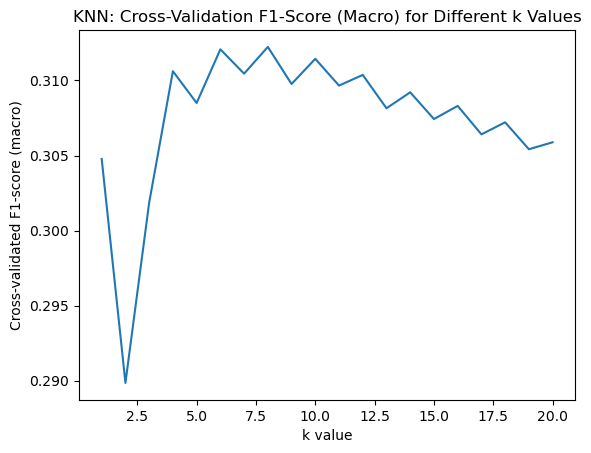

In [14]:
k_range = range(1, 21)
f1_scores = []

best_k = None
best_f1_score = -np.inf

for k in k_range:
    model = KNeighborsClassifier(n_neighbors=k)
    
    f1_scorer = make_scorer(f1_score, average='macro')
    
    cv_scores = cross_val_score(model, X_train[best_10_features], y_train, cv=5, scoring = f1_scorer)
    mean_f1_score = np.mean(cv_scores)
    f1_scores.append(mean_f1_score)
    
    if mean_f1_score > best_f1_score:
        best_f1_score = mean_f1_score
        best_k_10 = k

    time.sleep(120)

# Print the best k value
print(f"The best k value is: {best_k_10}")
print(f"The best F1-score (macro) is: {best_f1_score}")

# Plot the F1 scores
plt.plot(k_range, f1_scores)
plt.xlabel('k value')
plt.ylabel('Cross-validated F1-score (macro)')
plt.title('KNN: Cross-Validation F1-Score (Macro) for Different k Values')
plt.show()


The best k value is: 4
The best F1-score (macro) is: 0.3061917255403769


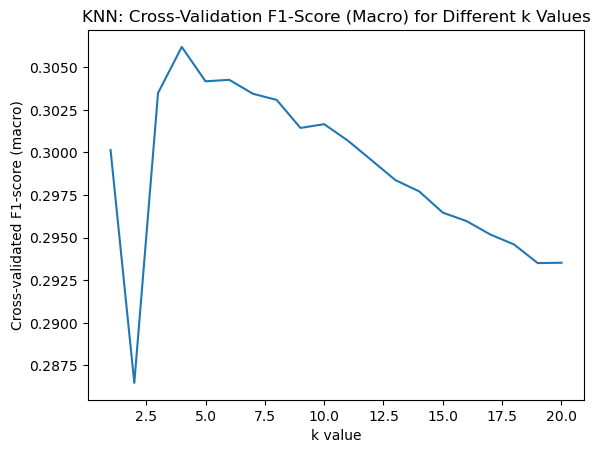

In [15]:
time.sleep(300)

k_range = range(1, 21)
f1_scores = []

best_k = None
best_f1_score = -np.inf

for k in k_range:
    model = KNeighborsClassifier(n_neighbors=k)
    
    f1_scorer = make_scorer(f1_score, average='macro')
    
    cv_scores = cross_val_score(model, X_train[best_20_features], y_train, cv=5, scoring = f1_scorer)
    mean_f1_score = np.mean(cv_scores)
    f1_scores.append(mean_f1_score)
    
    if mean_f1_score > best_f1_score:
        best_f1_score = mean_f1_score
        best_k_20 = k
    
    time.sleep(200)

# Print the best k value
print(f"The best k value is: {best_k_20}")
print(f"The best F1-score (macro) is: {best_f1_score}")

# Plot the F1 scores
plt.plot(k_range, f1_scores)
plt.xlabel('k value')
plt.ylabel('Cross-validated F1-score (macro)')
plt.title('KNN: Cross-Validation F1-Score (Macro) for Different k Values')
plt.show()

#### Run the model using K-fold and the K selected

In [ ]:
time.sleep(300)
X = X.reset_index(drop=True) 
y = y.reset_index(drop=True)

k = best_k_10
n_splits = 5

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

accuracies = []
f1_scores = []
fold_predictions_best_10 = []

for train_index, val_index in kf.split(X_train):

    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    y_train, y_val = encoding_label(y_train, y_val)
    X_train_model, X_val = preprocessing_scaling_encoding_dum(X_train, X_val)


    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_model[best_10_features], y_train)
    
    y_pred = model.predict(X_val[best_10_features])
    
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro')
    
    accuracies.append(accuracy)
    f1_scores.append(f1)

    X_train, X_test = preprocessing_scaling_encoding_dum(X_train, test_data)
    
    # Predict on test data with the current model
    y_test_pred = model.predict(X_test[best_10_features])
    fold_predictions_best_10.append(model.predict_proba(X_test[best_10_features]))

    time.sleep(210)

fold_predictions_best_10 = np.mean(fold_predictions_best_10, axis=0)
y_test_pred_knn_10 = np.argmax(fold_predictions_best_10, axis=1)

mean_accuracy = np.mean(accuracies)
mean_f1_score = np.mean(f1_scores)

print(f"Average accuracy across {n_splits}-fold cross-validation: {mean_accuracy}")
print(f"Average F1-score across {n_splits}-fold cross-validation: {mean_f1_score}")

# Print the accuracy and F1-score matrix
print("\nAccuracy Matrix:")
for i in range(n_splits):
    print(f"Fold {i+1} - Accuracy: {accuracies[i]}, F1-score (macro): {f1_scores[i]}")

/Users/philippedutranoit/document ordi/nova/machine learning /project/ML_Group36/src/Preprocessing_functions.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[coulmns] = X_train[coulmns].astype(str)
/Users/philippedutranoit/document ordi/nova/machine learning /project/ML_Group36/src/Preprocessing_functions.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[coulmns] = X_val[coulmns].astype(str)
/Users/philippedutranoit/document ordi/nova/machine learning /project/ML_Group36/src/Preprocessi

Average accuracy across 5-fold cross-validation: 0.7357889464744567
Average F1-score across 5-fold cross-validation: 0.31304914859374466

Accuracy Matrix:
Fold 1 - Accuracy: 0.7371303514655285, F1-score (macro): 0.31203012318956513
Fold 2 - Accuracy: 0.733112669308828, F1-score (macro): 0.3132094890100248
Fold 3 - Accuracy: 0.7364444057314576, F1-score (macro): 0.3142871521278007
Fold 4 - Accuracy: 0.7348547537128174, F1-score (macro): 0.311997600417097
Fold 5 - Accuracy: 0.7374025521536518, F1-score (macro): 0.3137213782242356


In [20]:
time.sleep(300)

X = X.reset_index(drop=True) 
y = y.reset_index(drop=True)

k = best_k_20
n_splits = 5

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

accuracies = []
f1_scores = []
fold_predictions_best_20 = []

for train_index, val_index in kf.split(X_train):

    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    y_train, y_val = encoding_label(y_train, y_val)
    X_train_model, X_val = preprocessing_scaling_encoding_dum(X_train, X_val)


    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_model[best_20_features], y_train)
    
    y_pred = model.predict(X_val[best_20_features])
    
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro')
    
    accuracies.append(accuracy)
    f1_scores.append(f1)

    X_train, X_test = preprocessing_scaling_encoding_dum(X_train, test_data)
    
    # Predict on test data with the current model
    y_test_pred = model.predict(X_test[best_20_features])
    fold_predictions_best_20.append(model.predict_proba(X_test[best_20_features]))

    time.sleep(210)

fold_predictions_best_20 = np.mean(fold_predictions_best_20, axis=0)
y_test_pred_knn_20 = np.argmax(fold_predictions_best_20, axis=1)

mean_accuracy = np.mean(accuracies)
mean_f1_score = np.mean(f1_scores)

print(f"Average accuracy across {n_splits}-fold cross-validation: {mean_accuracy}")
print(f"Average F1-score across {n_splits}-fold cross-validation: {mean_f1_score}")

# Print the accuracy and F1-score matrix
print("\nAccuracy Matrix:")
for i in range(n_splits):
    print(f"Fold {i+1} - Accuracy: {accuracies[i]}, F1-score (macro): {f1_scores[i]}")

/Users/philippedutranoit/document ordi/nova/machine learning /project/ML_Group36/src/Preprocessing_functions.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[coulmns] = X_train[coulmns].astype(str)
/Users/philippedutranoit/document ordi/nova/machine learning /project/ML_Group36/src/Preprocessing_functions.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[coulmns] = X_val[coulmns].astype(str)
/Users/philippedutranoit/document ordi/nova/machine learning /project/ML_Group36/src/Preprocessi

Average accuracy across 5-fold cross-validation: 0.7116451173868662
Average F1-score across 5-fold cross-validation: 0.306848393209284

Accuracy Matrix:
Fold 1 - Accuracy: 0.7120406600884654, F1-score (macro): 0.30113874215916203
Fold 2 - Accuracy: 0.7135292616536237, F1-score (macro): 0.30481428558597246
Fold 3 - Accuracy: 0.707787512759442, F1-score (macro): 0.31034175581167855
Fold 4 - Accuracy: 0.7111049676760803, F1-score (macro): 0.30751420441647015
Fold 5 - Accuracy: 0.71376318475672, F1-score (macro): 0.3104329780731367


#### run the model Xgbclassifier

/Users/philippedutranoit/document ordi/nova/machine learning /project/ML_Group36/src/Preprocessing_functions.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[coulmns] = X_train[coulmns].astype(str)
/Users/philippedutranoit/document ordi/nova/machine learning /project/ML_Group36/src/Preprocessing_functions.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[coulmns] = X_val[coulmns].astype(str)
/Users/philippedutranoit/document ordi/nova/machine learning /project/ML_Group36/src/Preprocessi

Optimal learning rate for accuracy: 0.1
Optimal learning rate for F1 score: 0.3


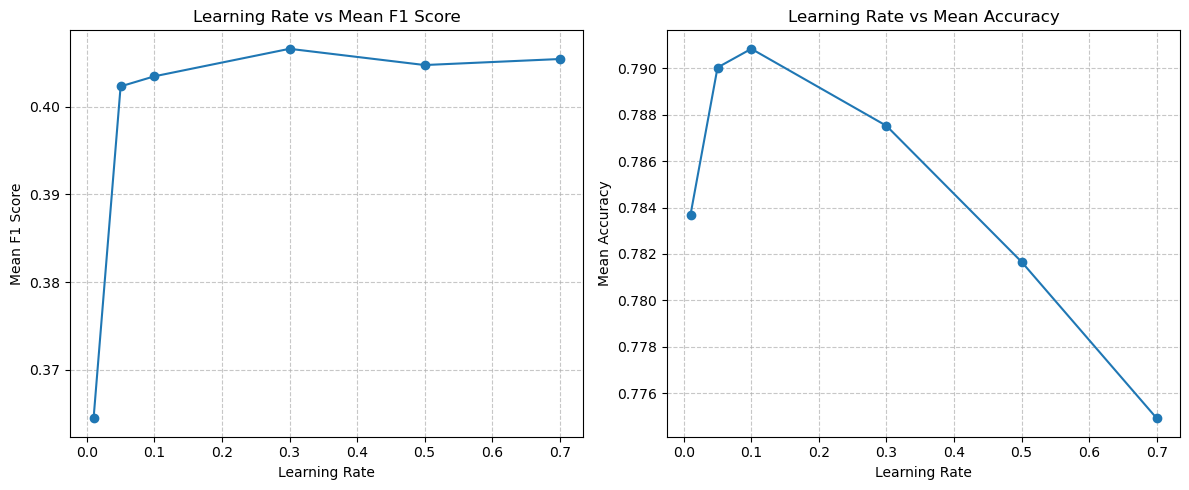

In [21]:
time.sleep(300)

# testing for different learning rates
learning_rate_range = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7]
n_splits = 5
random_state = 42

accuracies_mean = []
f1_scores_mean = []
# stetting a disctionary to store prediction on X_test
y_test_predictions_xgboost_no_outlier = {}

kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)


for learning_rate in learning_rate_range:

    accuracies = []
    f1_scores = []
    fold_predictions = []

    for train_index, test_index in kf.split(X):

        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        # changing X_train to another variable name to avoid data leackage as it as to be reprepossed to predict on x_test
        y_train, y_val = encoding_label(y_train, y_val)
        X_train_model, X_val = preprocessing_encoding_no_outlier(X_train, X_val)

        model = XGBClassifier(
            n_estimators=500,
            learning_rate=learning_rate,
            max_depth=6,
            min_child_weight=1,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='multi:softprob',
            n_jobs=-1
        )

        model.fit(X_train_model, y_train)
        time.sleep(30)
        y_pred = model.predict(X_val)
        accuracies.append(accuracy_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred, average='macro'))

        # Prepare test data prediction
        _ , X_test_preprocessed = preprocessing_encoding_no_outlier(X_train, test_data)
        fold_predictions.append(model.predict_proba(X_test_preprocessed))
        time.sleep(120)

    # Average predictions across folds
    fold_predictions = np.mean(fold_predictions, axis=0)
    y_test_pred = np.argmax(fold_predictions, axis=1)

    # Store results
    accuracies_mean.append(np.mean(accuracies))
    f1_scores_mean.append(np.mean(f1_scores))
    y_test_predictions_xgboost_no_outlier[f"lr_{learning_rate}"] = y_test_pred

    time.sleep(210)

# Find optimal learning rates
optimal_lr_accuracy = learning_rate_range[np.argmax(accuracies_mean)]
optimal_lr_f1 = learning_rate_range[np.argmax(f1_scores_mean)]

# Print results
print(f"Optimal learning rate for accuracy: {optimal_lr_accuracy}")
print(f"Optimal learning rate for F1 score: {optimal_lr_f1}")

# Visualization
plt.figure(figsize=(12, 5))

# F1 Score Plot
plt.subplot(1, 2, 1)
plt.plot(learning_rate_range, f1_scores_mean, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Mean F1 Score')
plt.title('Learning Rate vs Mean F1 Score')
plt.grid(True, linestyle='--', alpha=0.7)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(learning_rate_range, accuracies_mean, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Accuracy')
plt.title('Learning Rate vs Mean Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

/Users/philippedutranoit/document ordi/nova/machine learning /project/ML_Group36/src/Preprocessing_functions.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[coulmns] = X_train[coulmns].astype(str)
/Users/philippedutranoit/document ordi/nova/machine learning /project/ML_Group36/src/Preprocessing_functions.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[coulmns] = X_val[coulmns].astype(str)
/Users/philippedutranoit/document ordi/nova/machine learning /project/ML_Group36/src/Preprocessi

Optimal learning rate for accuracy: 0.1
Optimal learning rate for F1 score: 0.5


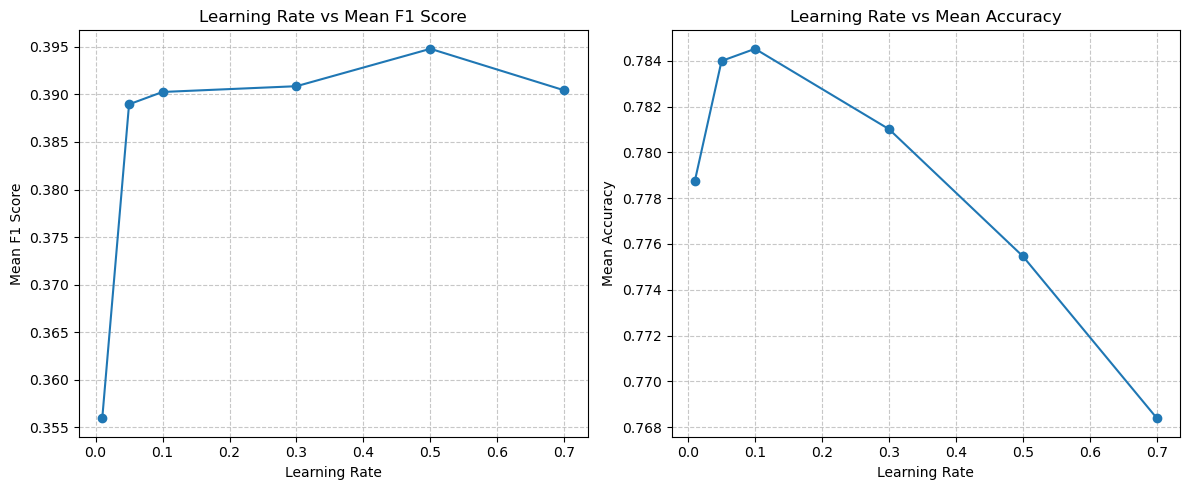

In [22]:
time.sleep(300)

# testing for different learning rates
learning_rate_range = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7]
n_splits = 5
random_state = 42

accuracies_mean = []
f1_scores_mean = []
# stetting a disctionary to store prediction on X_test
y_test_predictions_xgboost_outlier = {}

kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)


for learning_rate in learning_rate_range:

    accuracies = []
    f1_scores = []
    fold_predictions = []

    for train_index, test_index in kf.split(X):

        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        # changing X_train to another variable name to avoid data leackage as it as to be reprepossed to predict on x_test
        y_train, y_val = encoding_label(y_train, y_val)
        X_train_model, X_val = preprocessing_encoding_dum(X_train, X_val)

        model = XGBClassifier(
            n_estimators=500,
            learning_rate=learning_rate,
            max_depth=6,
            min_child_weight=1,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='multi:softprob',
            n_jobs=-1
        )

        model.fit(X_train_model, y_train)
        time.sleep(30)
        y_pred = model.predict(X_val)
        accuracies.append(accuracy_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred, average='macro'))

        # Prepare test data prediction
        _, X_test_preprocessed = preprocessing_encoding_dum(X_train, test_data)
        fold_predictions.append(model.predict_proba(X_test_preprocessed))
        time.sleep(120)

    # Average predictions across folds
    fold_predictions = np.mean(fold_predictions, axis=0)
    y_test_pred = np.argmax(fold_predictions, axis=1)

    # Store results
    accuracies_mean.append(np.mean(accuracies))
    f1_scores_mean.append(np.mean(f1_scores))
    y_test_predictions_xgboost_outlier[f"lr_{learning_rate}"] = y_test_pred
    time.sleep(210)

# Find optimal learning rates
optimal_lr_accuracy = learning_rate_range[np.argmax(accuracies_mean)]
optimal_lr_f1 = learning_rate_range[np.argmax(f1_scores_mean)]

# Print results
print(f"Optimal learning rate for accuracy: {optimal_lr_accuracy}")
print(f"Optimal learning rate for F1 score: {optimal_lr_f1}")

# Visualization
plt.figure(figsize=(12, 5))

# F1 Score Plot
plt.subplot(1, 2, 1)
plt.plot(learning_rate_range, f1_scores_mean, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Mean F1 Score')
plt.title('Learning Rate vs Mean F1 Score')
plt.grid(True, linestyle='--', alpha=0.7)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(learning_rate_range, accuracies_mean, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Accuracy')
plt.title('Learning Rate vs Mean Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()